# Package Import

In [1]:
### import
import random as rand
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay

from scipy.stats import iqr

from statsmodels.miscmodels.ordinal_model import OrderedModel

# Load Data & Preprocess Func


In [2]:
### missing value
# x should be pandas dataframe
def KNN_Impute(x, k):
    knn_impute = KNNImputer(n_neighbors=k) # n_neighbors, weights
    x = knn_impute.fit_transform(x)
    for i in range(x.shape[0]):
        x[i][1] = round(x[i][1])
    return x

def KNN_Impute_iqrs(x, k):
    iqrs = x.apply(lambda x: np.nanquantile(x, 0.75) - np.nanquantile(x, 0.25))
    if x.shape[1] == 17:
        iqrs[13:16] = 1
    x = x / iqrs
    knn_impute = KNNImputer(n_neighbors=k) # n_neighbors, weights
    x = knn_impute.fit_transform(x)
    x = x * iqrs.to_numpy()
    for i in range(x.shape[0]):
        x[i][1] = round(x[i][1])
    return x

In [ ]:
### load training data with pandas
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv", delimiter=",", header=0)
train_df = train_df.drop(['id','Track','Album','Uri','Url_spotify','Url_youtube','Description','Title','Channel','Composer','Artist'], axis =1)
n_train = train_df.shape[0]

y_train_pd = train_df[['Danceability']].copy()
y_train    = y_train_pd.to_numpy()
y_train    = np.reshape(y_train, n_train)

x_train_pd17 = train_df.copy()
x_train_pd17 = x_train_pd17.drop(['Danceability'], axis =1)
x_train_pd14 = x_train_pd17.drop(['Album_type','official_video','Licensed'], axis =1)

album_map = {'album': 3, 'single': 2, 'compilation': 1}
tf_map = {1: 1, 0: 0}
x_train_pd17['Album_type'] = x_train_pd17['Album_type'].map(album_map, na_action='ignore')
x_train_pd17['official_video'] = x_train_pd17['official_video'].map(tf_map, na_action='ignore')
x_train_pd17['Licensed'] = x_train_pd17['Licensed'].map(tf_map, na_action='ignore')

pd.set_option('display.max_columns', 500)                                      
print(x_train_pd17.head(3))
x_train17      = x_train_pd17.to_numpy()
x_train17_knn  = KNN_Impute_iqrs(x_train_pd17, 5)
x_train14      = x_train_pd14.to_numpy()
x_train14_knn  = KNN_Impute_iqrs(x_train_pd14, 5)

# Evaluation Func

In [5]:
### Search Result
def Search_Result(res):
    print("mean")
    print(res.cv_results_['mean_test_score'])
    print("std")
    print(res.cv_results_['std_test_score'])
    print("rank")
    print(res.cv_results_['rank_test_score'])
    print(res.best_params_)
    print(res.best_score_)

In [6]:
### CV Interpretation
def CV_Average(score, msg):
    fold = score.shape[0]
    sum = 0
    for f in range(fold):
        sum += score[f]
    print(msg)
    print('average: ' + str(sum/fold))
    print('indiv.: '+str(score))

In [38]:
### Output Manipulation
def Reg_for_Cla(y):
    y = y.round()
    for i in range(y.shape[0]):
        for j in range (y.shape[1]):
            if   y[i][j] < 0:
                y[i][j] = 0
            elif y[i][j] > 9:
                y[i][j] = 9
    return y

def Reg_for_Cla2(y):
    y = y + ((y - 4.5) / 10) * np.abs((y - 4.5) / 10)
    y = y.round()
    for i in range(y.shape[0]):
        for j in range (y.shape[1]):
            if   y[i][j] < 0:
                y[i][j] = 0
            elif y[i][j] > 9:
                y[i][j] = 9
    return y

# Models

[Hist Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)

1.6718112987769365

best 5f-cv avg: 1.687 (original input w/ NaN & rounded output)

somehow regressor is better than classifier (maybe because considers ordered relation?)

In [75]:
ada = make_pipeline(AdaBoostRegressor(n_estimators=1000))
x_train = x_train17_knn
cv_score = cross_val_score(ada, x_train, y_train, cv=5, scoring="neg_mean_absolute_error")
CV_Average(cv_score, "ada")

ada
average: -2.0983947601000685
indiv.: [-2.06 -2.16 -2.09 -2.06 -2.12]


In [43]:
### Gradient Boosting Decision Tree (Pick one to run!)
"""
x_train = x_train14 # x_train14_knn

gbr   = make_pipeline(HistGradientBoostingRegressor(loss='absolute_error'))
gbr_p = make_pipeline(HistGradientBoostingRegressor(loss='absolute_error', 
                                                    min_samples_leaf=150, max_leaf_nodes=33, max_depth=14, max_bins=225, learning_rate=0.1, l2_regularization=0.1))
gbr_r = TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(loss='absolute_error'), inverse_func=Reg_for_Cla, check_inverse=False)
gbr_rp= TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(loss='absolute_error', 
                                                    min_samples_leaf=150, max_leaf_nodes=33, max_depth=14, max_bins=225, learning_rate=0.1, l2_regularization=0.1), inverse_func=Reg_for_Cla, check_inverse=False)
"""
x_train = x_train17 # x_train17_knn

gbr   = make_pipeline(HistGradientBoostingRegressor(loss='absolute_error', categorical_features=[13, 14, 15]))
gbr_p = make_pipeline(HistGradientBoostingRegressor(loss='absolute_error', categorical_features=[13, 14, 15], 
                                                    min_samples_leaf=150, max_leaf_nodes=33, max_depth=14, max_bins=225, learning_rate=0.1, l2_regularization=0.1))
gbr_r = TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(loss='absolute_error', categorical_features=[13, 14, 15], random_state=6211), inverse_func=Reg_for_Cla, check_inverse=False)
gbr_rp1= TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(loss='absolute_error', categorical_features=[13, 14, 15], random_state=6211, 
                                                    min_samples_leaf=80, max_leaf_nodes=33, max_depth=40, max_bins=195, l2_regularization=0.03), inverse_func=Reg_for_Cla, check_inverse=False)
gbr_rp2= TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(loss='absolute_error', categorical_features=[13, 14, 15], random_state=6211, 
                                                    min_samples_leaf=80, max_leaf_nodes=33, max_depth=40, max_bins=195, l2_regularization=0.03), inverse_func=Reg_for_Cla, check_inverse=False)
# """
print("Check Dimension"+str(x_train.shape))
#min_samples_leaf=150, max_leaf_nodes=33, max_depth=14, max_bins=225, learning_rate=0.1, l2_regularization=0.1

Check Dimension(17170, 17)


In [ ]:
### Parameter Search
param_dist = {'regressor__max_leaf_nodes': [24, 27, 30, 33, 36],          #31
              'regressor__max_depth': [10, 20, 40],                       #inf
              'regressor__min_samples_leaf': [20, 80, 150, 200],          #20
              'regressor__l2_regularization': [0, 0.03, 0.1, 0.3],        #0
              'regressor__max_bins': [195, 225, 255]}                     #255 (<=255)
random_search = RandomizedSearchCV(estimator=gbr_r, param_distributions=param_dist, scoring='neg_mean_absolute_error', n_iter=50, cv=5)
random_search.fit(x_train, y_train)

# Access the results
results     = random_search.cv_results_
best_params = random_search.best_params_
best_score  = random_search.best_score_
print(results['mean_test_score'])
print(results['rank_test_score'])
print(best_params)
print(best_score)
#{'regressor__min_samples_leaf': 80, 'regressor__max_leaf_nodes': 33, 'regressor__max_depth': 40, 'regressor__max_bins': 195, 'regressor__l2_regularization': 0.03} 1.6626

In [ ]:
### Parameter Search
param_dist = {'regressor__random_state': [1126, 6211, None],
              'regressor__max_depth': [20, 80, 140, 200, None],                     
              'regressor__l2_regularization': [0.01, 0.03, 0.1, 0.3, 1, 3]}
grid_search = GridSearchCV(estimator=gbr_r, param_grid=param_dist, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(x_train, y_train)

Search_Result(grid_search)

In [44]:
### Cross Validation: change estimator name
cv_score = cross_val_score(gbr_rp1, x_train, y_train, cv=5, scoring="neg_mean_absolute_error")
CV_Average(cv_score, "original output")
cv_score = cross_val_score(gbr_rp2, x_train, y_train, cv=5, scoring="neg_mean_absolute_error")
CV_Average(cv_score, "with rounding")

original output
average: -1.6659871869539895
indiv.: [-1.63 -1.67 -1.62 -1.7  -1.71]
with rounding
average: -1.6825859056493886
indiv.: [-1.63 -1.68 -1.64 -1.7  -1.76]


In [ ]:
x_train3, x_eval, y_train3, y_eval = train_test_split(x_train, y_train)

y1 = np.empty((4293, 2))
gbr_model = gbr_p.fit(x_train3, y_train3)
y1[::,1] = gbr_model.predict(x_eval)
y1[::,0] = y_eval
y1 = y1[y1[:,1].argsort()]

from scipy.stats import gaussian_kde
xy = np.vstack([y1[:,0],y1[:,1]])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(y1[:,0], y1[:,1], c=z, s=50)
plt.show()

y2 = np.empty((4293, 2))
gbr_model = gbr.fit(x_train3, y_train3)
y2[::,1] = gbr_model.predict(x_eval)
y2[::,0] = y_eval
y2 = y2[y2[:,1].argsort()]
print(y2[192:212][::])

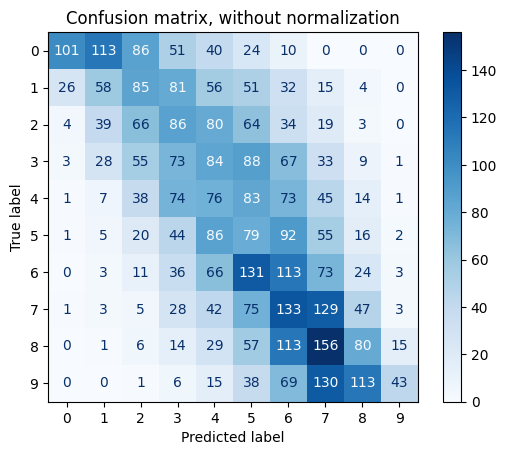

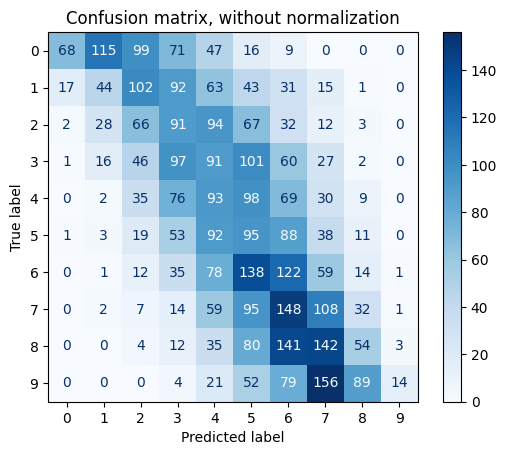

In [45]:
### Confusion Matrix on Classifier
x_train3, x_eval, y_train3, y_eval = train_test_split(x_train, y_train)

gbr_model = gbr_rp1.fit(x_train3, y_train3)
y_pred = gbr_model.predict(x_eval)
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None)]#,
                  #("Normalized confusion matrix", "true"),]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(y_eval, y_pred,
        display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
        cmap=plt.cm.Blues,
        normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

gbr_model = gbr_rp2.fit(x_train3, y_train3)
y_pred = gbr_model.predict(x_eval)
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None)]#,
                  #("Normalized confusion matrix", "true"),]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(y_eval, y_pred,
        display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
        cmap=plt.cm.Blues,
        normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

# Prediction

In [ ]:
### load data
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv", delimiter=",", header=0)
n_test = test_df.shape[0]

id = test_df[['id']].copy()
id = id.to_numpy()
submit = np.zeros((n_test, 2))
submit[:, 0] = id[:, 0]

x_test_pd17 = test_df.copy()
x_test_pd17 = x_test_pd17.drop(['id','Track','Album','Uri','Url_spotify','Url_youtube','Description','Title','Channel','Composer','Artist'], axis =1)
x_test_pd14 = x_test_pd17.drop(['Album_type','official_video','Licensed'], axis =1)

album_map = {'album': 3, 'single': 2, 'compilation': 1}
tf_map = {1: 1, 0: 0}
x_test_pd17['Album_type']     = x_test_pd17['Album_type'].map(album_map, na_action='ignore')
x_test_pd17['official_video'] = x_test_pd17['official_video'].map(tf_map, na_action='ignore')
x_test_pd17['Licensed']       = x_test_pd17['Licensed'].map(tf_map, na_action='ignore')
#pd.set_option('display.max_columns', 500)                                      
#print(x_test_pd17.head(3))

In [43]:
### make prediction
x_test    = x_test_pd17.to_numpy() #choose x
gbr_r2p.fit(x_train, y_train) #change model name
submit[:, 1] = gbr_r2p.predict(x_test) #change model name again

df = pd.DataFrame(submit, columns = ['id','Danceability'])
df = df.astype({"id": int})
df.to_csv('submission.csv', index=False)

# Past Trials


In [ ]:
### Parameter Search
param_dist = {'regressor__max_depth': [5, 20, 80, 140, 200, None],                     
              'regressor__l2_regularization': [0.01, 0.03, 0.1, 0.3, 1, 3]}
grid_search = GridSearchCV(estimator=gbr_r, param_grid=param_dist, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(x_train, y_train)

Search_Result(grid_search)
# Result on x_train_17
# 'l2_regularization': 3, 'max_depth': None  cv_socre: 1.6642399534071053
# depth = 5 consistently bad
# depth = none needs at least l2=0.03

In [ ]:
### Effect of Random State
param_dist = {'regressor__random_state': [0, 10, 1126, 6211, 100000, None]}                     #255 (<=255)
grid_search = GridSearchCV(estimator=gbr_r, param_grid=param_dist, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(x_train, y_train)

Search_Result(grid_search)
# Done on x_train17
# Result: Use None